In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
%matplotlib inline
from PIL import Image

In [22]:
feat_path = '/home/b.mqua/datasets/gravity/data/tutti/images/tutti_images_googlenet/pool5_7x7_s1_norm.npz' 
img_files = '/home/b.mqua/datasets/gravity/data/tutti/images/tutti_images_resized.txt'
session_path = '/home/b.mqua/datasets/gravity/data/processed/tutti_img_train_valid.txt'

In [23]:
img_paths = [x.split()[0] for x in open(img_files, 'r')]
ids = [int(re.findall('\d+',x)[0]) for x in img_paths]
pathmap = pd.Series(data=img_paths, index=ids)
idmap = pd.Series(data=np.arange(len(ids)), index=ids)

In [24]:
data = pd.read_csv(session_path, sep='\t', dtype={'SessionId':np.int32, 'ItemId':np.int32})

In [25]:
sessions = data.SessionId.unique()

In [26]:
# WARNING: REQUIRES TONS OF MEMORY 
pf = np.load(feat_path).items()[0][1]

In [27]:
pf = pf.squeeze()

In [28]:
#pf_sample.shape

In [29]:
intrasim = lambda feats: np.mean([np.dot(f1, f2) for f1, f2 in zip(feats[:-1], feats[1:])])

In [30]:
intra_session_sims = data.groupby(data.SessionId).apply(lambda x: intrasim(pf[idmap[x.ItemId]]))

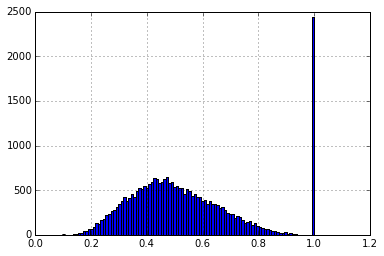

In [31]:
intra_session_sims.hist(bins=100)

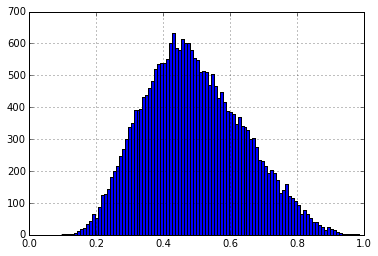

In [32]:
# remove sessions with sim = 1 (only one (same) item watched through the session)
intra_session_sims[intra_session_sims < 0.99].hist(bins=100)

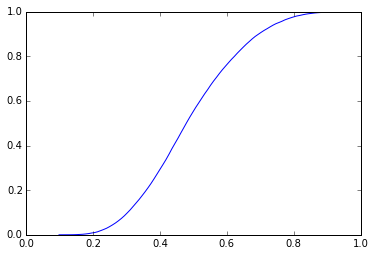

In [33]:
hist, bin_edges = np.histogram(intra_session_sims[intra_session_sims < 0.99], bins=100)
hist_cum = np.cumsum(np.r_[[0], hist], dtype=np.float32)
plt.plot(bin_edges, hist_cum/hist_cum[-1])

In [34]:
session_lengths = data.groupby(data.SessionId).size()

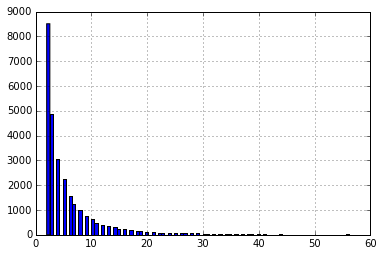

In [35]:
session_lengths[session_lengths < 60].hist(bins=100)

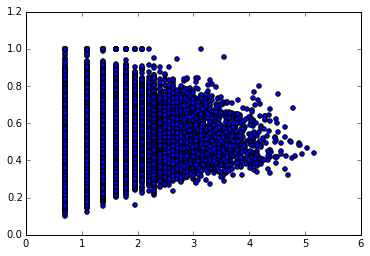

In [36]:
plt.scatter(np.log(session_lengths), intra_session_sims)

In [41]:
def show_session(sess_id):
    ids = data[data.SessionId == sess_id].ItemId.values
    f, axes = plt.subplots(1, len(ids), figsize=(15,2))
    f.suptitle('Sid = {}, score = {:.4f}'.format(sess_id, intra_session_sims[sess_id]))
    feats = pf[idmap[ids]]
    for ax, iid in zip(axes, ids):
        ax.imshow(Image.open(pathmap[iid]))
        ax.axis('off')

In [38]:
def show_random_sessions(n=10):
    sids = np.random.choice(sessions, size=n)
    for sid in sids:
        show_session(sid)

In [39]:
def show_rnd_sessions_by_sim(n=10, min_sim=0, max_sim=1):
    chosen_sess = intra_session_sims[(intra_session_sims >= min_sim) & (intra_session_sims < max_sim)].index.values
    sids = np.random.choice(chosen_sess, size=n)
    for sid in sids:
        show_session(sid)

In [62]:
def show_first_sessions_with_sim(n=10, min_sim=0, max_sim=1, minlen=1):
    chosen_sess = intra_session_sims[(intra_session_sims >= min_sim) & (intra_session_sims < max_sim)].index.values
    chosen_sess = chosen_sess[(session_lengths[chosen_sess] >= minlen).values]
    sids = chosen_sess[:n]
    for sid in sids:
        show_session(sid)

# RANDOM SESSIONS

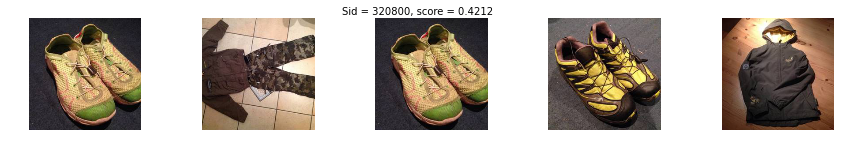

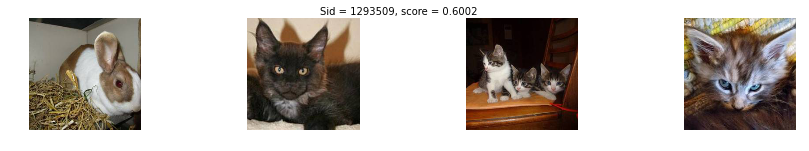

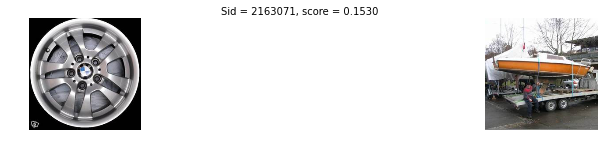

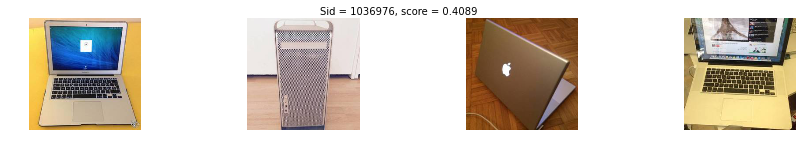

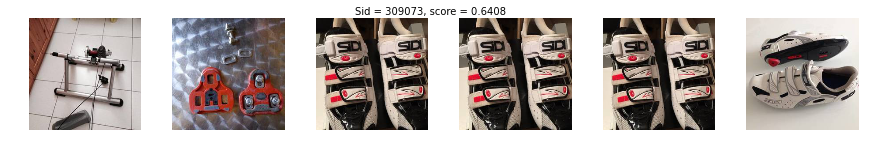

In [42]:
show_random_sessions(5)

# sim <= 0.1 (bad sessions)

In [233]:
print 'count: {}'.format(np.sum(intra_session_sims < 0.1))

count: 19


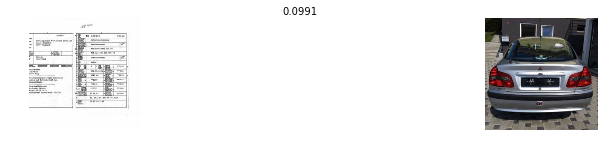

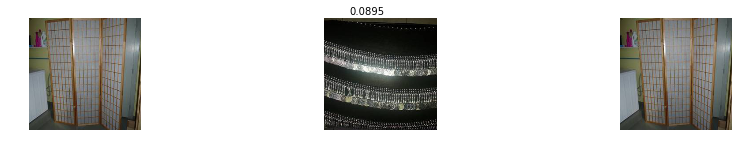

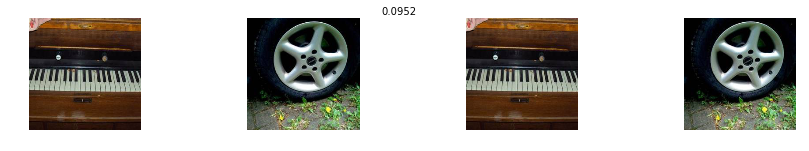

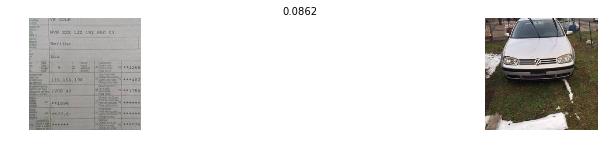

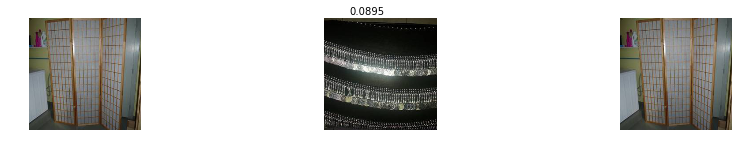

In [234]:
show_rnd_sessions_by_sim(n=5, max_sim=.1)

# 0.1 <= sim <= 0.2 (still not very good...)

In [236]:
print 'perc. sessions: {:.2f}%'.format(float(np.sum(np.logical_and(intra_session_sims >=0.1, intra_session_sims < 0.2))) 
                                   / intra_session_sims.shape[0]*100)

perc. sessions: 0.95%


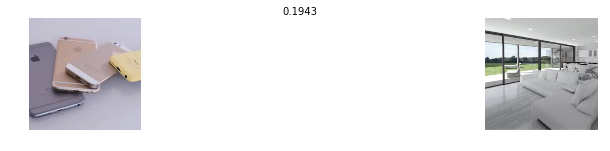

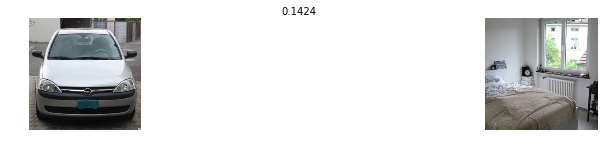

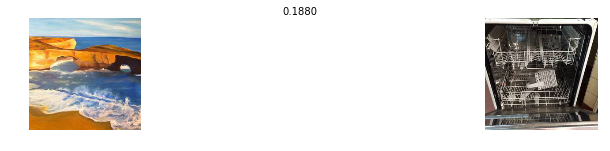

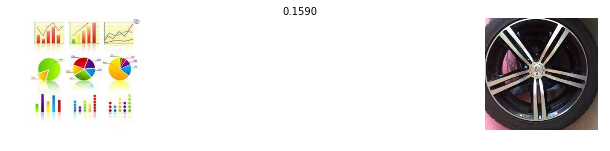

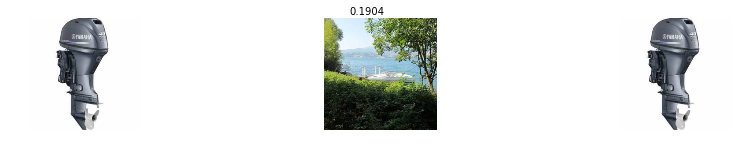

In [238]:
show_rnd_sessions_by_sim(n=5, min_sim=.1, max_sim=.2)

# 0.2 <= sim <= 0.3

In [262]:
print 'perc. sessions: {:.2f}%'.format(float(np.sum(np.logical_and(intra_session_sims >=0.2, intra_session_sims <= 0.3)))
                         / intra_session_sims.shape[0] * 100)

perc. sessions: 9.60%


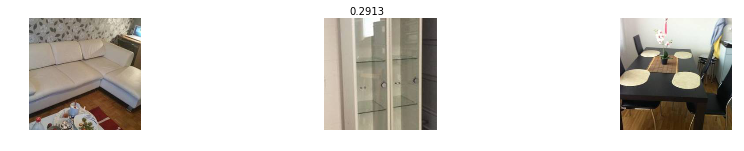

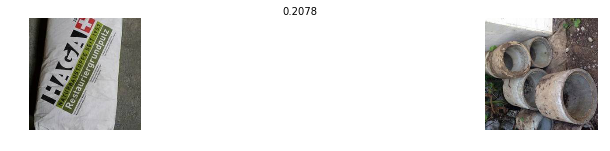

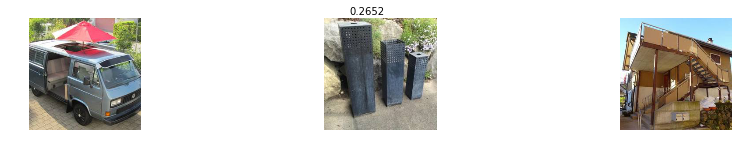

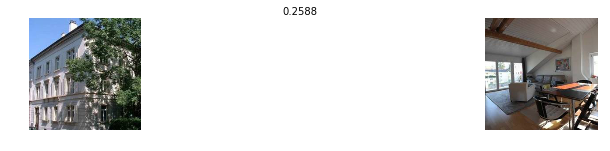

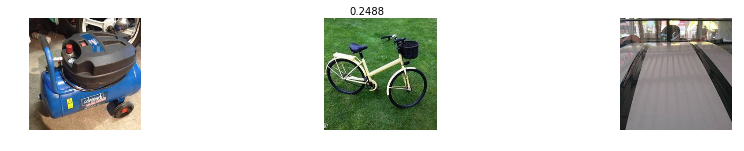

In [263]:
show_rnd_sessions_by_sim(n=5, min_sim=.2, max_sim=.3)

# 0.3 <= sim <= 0.4 (things are getting better...)

In [264]:
print 'perc. sessions: {:.2f}%'.format(float(np.sum(np.logical_and(intra_session_sims >=0.3, intra_session_sims < 0.4)))
                         / intra_session_sims.shape[0] * 100)

perc. sessions: 19.52%


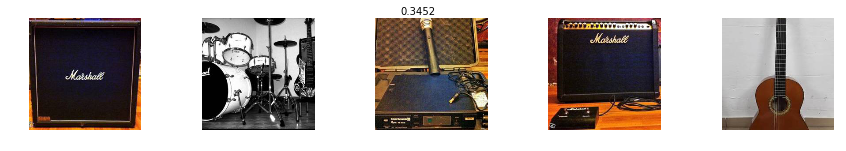

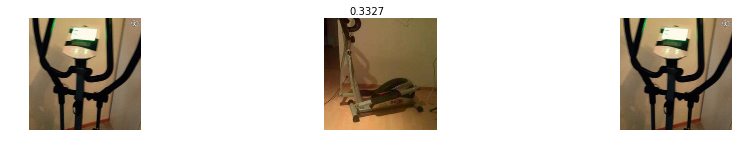

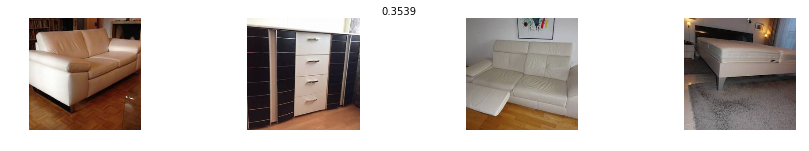

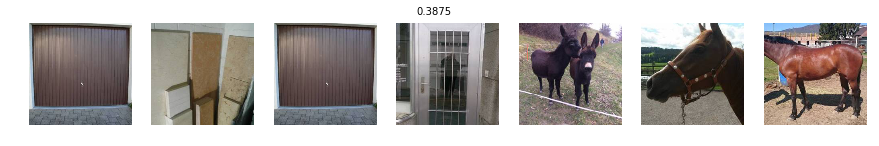

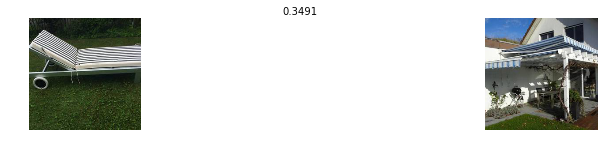

In [265]:
show_rnd_sessions_by_sim(n=5, min_sim=.3, max_sim=.4)

0.4 <= sim <= 0.99 (ok, things make sense now!)

In [43]:
print 'perc. sessions: {:.2f}%'.format(float(np.sum(np.logical_and(intra_session_sims >=0.4, intra_session_sims < 0.99)))
                         / intra_session_sims.shape[0] * 100)

perc. sessions: 64.51%


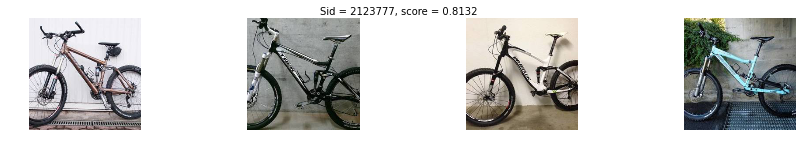

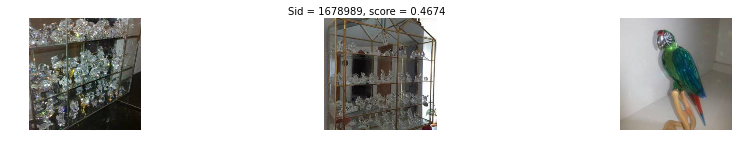

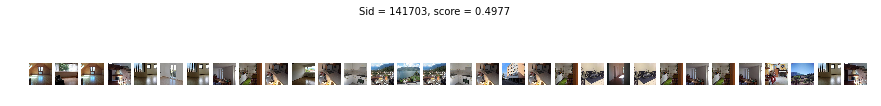

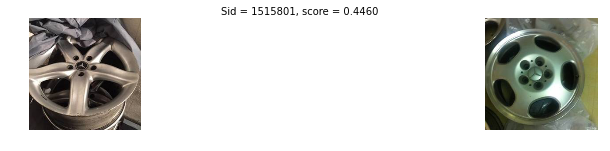

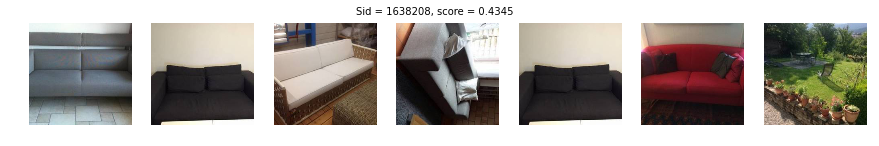

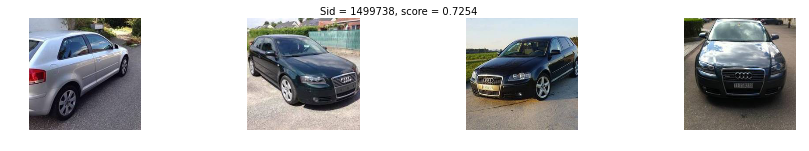

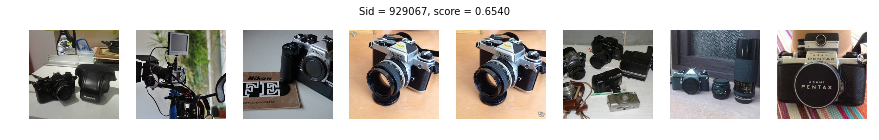

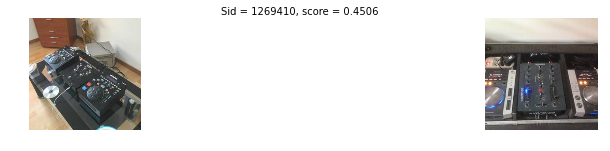

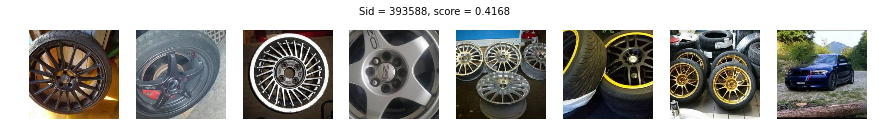

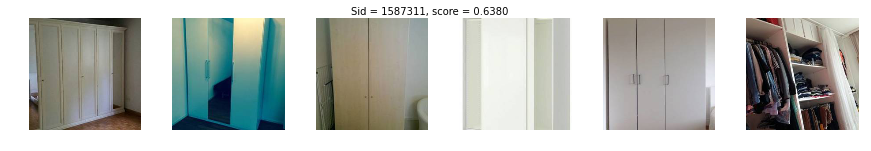

In [44]:
show_rnd_sessions_by_sim(n=10, min_sim=.4, max_sim=0.9)

0.99 <= sim <= 1.0 (the same item over and over...)

In [260]:
print 'perc. sessions: {:.2f}%'.format(float(np.sum(intra_session_sims >=0.99))
                         / intra_session_sims.shape[0]*100)

perc. sessions: 11.04%


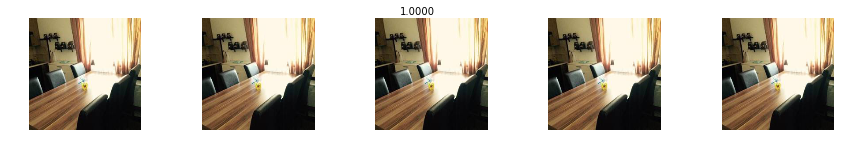

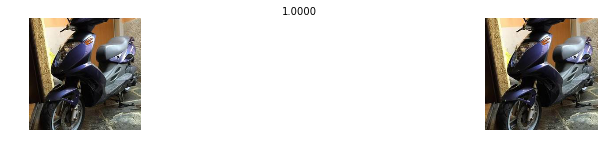

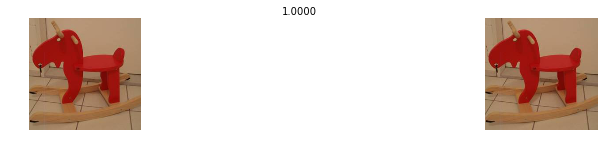

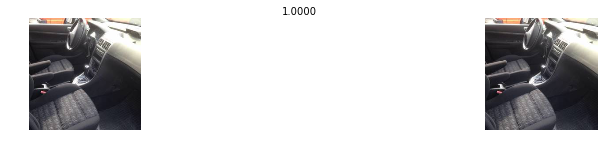

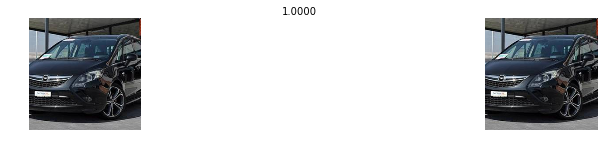

In [261]:
show_rnd_sessions_by_sim(n=5, min_sim=0.99, max_sim=1)

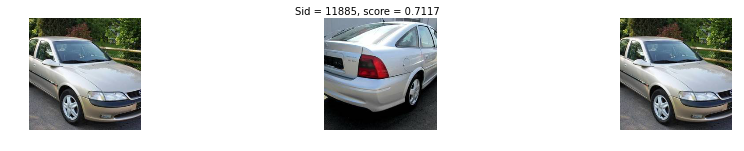

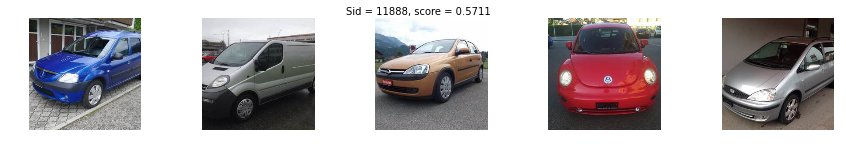

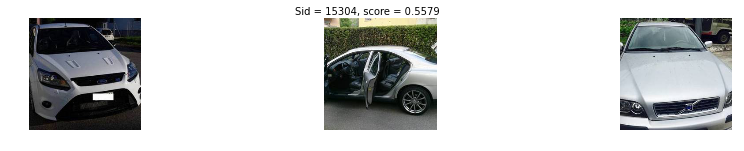

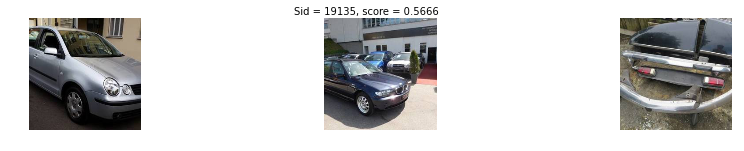

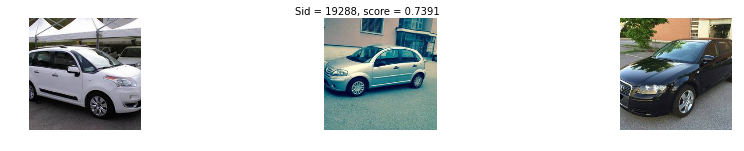

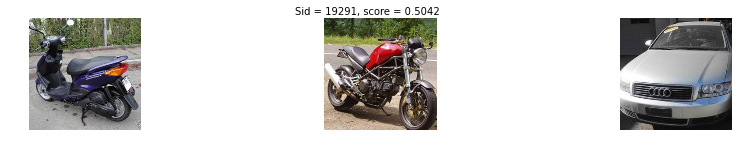

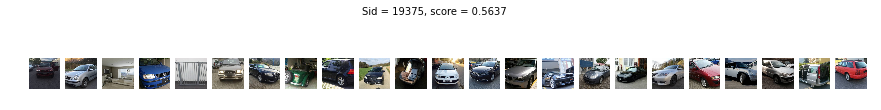

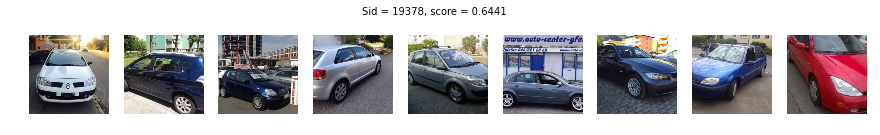

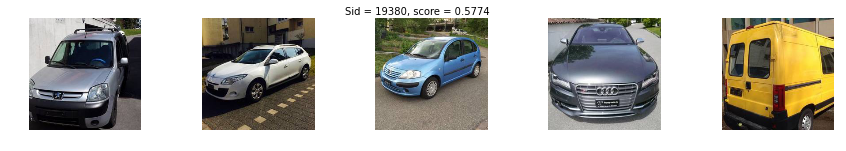

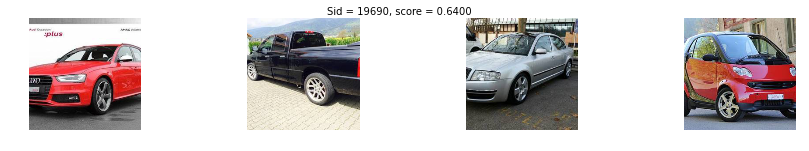

In [63]:
show_first_sessions_with_sim(10, 0.5, 0.8, 3)